16.32 - Redes Neuronales en Bioingenería, ITBA
# TP2 - The Rossman Challenge
André Torvestad - October 2022

The objective of the exercise is to create a model able to forecast sales at Rossman stores using a deep neural network (DNN). The model will be trained using store, promotion and competitor data as provided in the course. 

Steps:
1. Process the data to a format accepted by the models
2. Create a model for prediction
3. Use different parameters to optimize the result
4. Present the model and it's score

### Table of Contents: 
1. Introduction
2. Explanation of Data Processing
3. Theory of Entity Embedding
4. Entity Embedding (from 'rossmann.ipynb')
5. Deep Neural Network Models
6. LGBM Model
7. Results
8. Bibliography



## 1. Introduction
The data processing is done using the file 'rossman.ipynb', as it is provided by the course. This delivery therefore focuses on the development of a DNN by using the techniques mentioned in the course. These techniques are within the field of optimization and regularization. 

By tuning the DNN the goal is to achieve an accuracy within the range of what was accomplished in the Rossman kaggle competition, with Root Mean Square Percentage Error (RMSPE) around 0.1. RMSPE is the metric of choice from the competition. 

An alternative model, the LGBM machine, is tried out to compare the performance of the DNN to a tree-based method. 

The models and their scores are discussed at the end. 

## 2. Explanation of Data Processing

The raw data is processed in the script 'rossman.ipynb':

#### Data Cleaning

The script first loads and gives an overview over the raw data files, which are: train, store, store_states, state_names, googletrend, weather. The first rows and a summary is shown to give an understanding of the data files. 

The date data are expanded into new columns, each containing year, month, week, day.

All data is then joined into a single dataframe, named 'joined'. This dataframe contains all data available of the stores. 

New features are extracted: "CompetitionOpenSince", "CompetitionDaysOpen" and "CompetitionMonthsOpen" are added. "CompetitionMonthsOpen" is limited to two years, 24 months, to limit the number of unique embeddings. The same procedure is done for Promo days. 

The dataframe 'joined' now contains all information available 

#### Durations

When working with time series, information about time elapsed is wanted. This is being extracted from the data. 

This section is extracting information about time from the datasets. By manipulating data information about durations are collected and can now be used in the prediction. This is a smart way of using time data to extract more information about the dataset. 

The duration dataframe is joined together with the main dataframe 'joined', which now contains the final set of engineered features. 

#### Metrics

The metrics used are a mixture of the data provided by Rossmann at the competition (train and store) and data collected by external sources such as store_states, googletrend and weather. A brief overview can be seen in the table below, provided in the file 'rossman.ipynb'. 

| Table        | Table Description                                                                                               |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| train        | training set: store information on a daily basis, tracking things like sales, customers, whether that day was a holiday, etc. |
| store        | general information about the store including competition, etc.                                                 |
| store_states | maps store to state it is in                                                                                    |
| state_names  | maps state abbreviations to names                                                                               |
| googletrend  | trend data for particular week/state                                                                            |
| weather      | weather conditions for each state                                                                               |


## 3. Theory of Entity Embedding

Entity embedding is making vectors represent things. These things are called entities. This opens up for performing operations on entities, as they are now mathematically defined - like as input to a neural network. (Zalkifli, 2019).   

As stated in the paper "Entity Embeddings of Categorical Variables" (Guo & Berkhahn, 2016), "entity embedding not only reduces memory usage and usage speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables". The authors furthermore demonstrates in the paper that entity embedding helps the neural network generalize features better, making it especially useful for datasets with many features. 

The paper furthermore states that the task of entity embedding is to map discrete values to a multi-dimensional space where values with similar function output are close to each other. Entity embedding thus is to make a representation of things, in our case of stores and their information, and make a mathematical representation of it into an Euclidean space. 

## 4. Entity Embedding

Below the code used in 'rossman.ipynb' is redone to better understand the entity embedding done. 

In [1]:
# Importar librarias 
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
import matplotlib.pyplot as plt, operator, random
import seaborn as sns
import numpy as np
import keras.backend as K
from sklearn.decomposition import PCA
from google.colab import drive
from keras import initializers as initializations
import tensorflow as tf
import math

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelEncoder


sns.set_theme()
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 7.3 MB/s 
Mounted at /content/drive


In [62]:
# Load the dataset from above
BASE = '/content/drive/MyDrive/Neural Networks/TP2/'
joined = pd.read_csv(BASE+'joined.csv')

Map categories to embedding dimensionality. More complex categories have a higher dimensionality. 

In [63]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

Name variables: categorical and continuous

In [64]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]


# mean/max wind; min temp; cloud; min/mean humid; 
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Replace nulls

In [65]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

Create a list of tuples, each containing a variable and an instance of a transformer for that variable. 

Categorical variables are mapped into continous integers. Continous are standardized. 

In [66]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

A dataframemapper is used to keep track of variable-instance mappings. 

In [67]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [68]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

16

Remove all instances of 0 and set the index to date. 

In [69]:
joined_sales = joined[joined.Sales!=0]
joined_sales = joined_sales.set_index("Date")

Split into training and validation set. Normally in machine learning this is done by picking random variables. This is not the case with time series (Radecic, 2021). The newest data should be used for validation and everything else for training. 

In [70]:
valid_ratio = 0.1
n = len(joined_sales)
valid_size = int(n * valid_ratio)

joined_train = joined_sales[valid_size:]
joined_valid = joined_sales[:valid_size]

print('Train length:',len(joined_train),', Valid length:', len(joined_valid))

Train length: 759905 , Valid length: 84433


The training and validation set are then ready for use.

Then a preprocessor for the categoricals and continous using the instance mapper is made.

In [71]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [72]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

Grab the sales numbers for the training and validation set.

In [73]:
y_train = joined_train.Sales
y_valid = joined_valid.Sales

In [74]:
max_log_y = np.max(np.log(joined_sales.Sales))
y_train = np.log(y_train)/max_log_y
y_valid = np.log(y_valid)/max_log_y

In [75]:
y_train, y_valid

(Date
 2015-05-02    0.847669
 2015-05-02    0.900999
 2015-05-02    0.759363
 2015-05-02    0.832863
 2015-05-02    0.838613
                 ...   
 2013-01-01    0.763930
 2013-01-01    0.872998
 2013-01-01    0.801545
 2013-01-01    0.790793
 2013-01-01    0.817420
 Name: Sales, Length: 759905, dtype: float64, Date
 2015-07-31    0.805709
 2015-07-31    0.819031
 2015-07-31    0.848704
 2015-07-31    0.897672
 2015-07-31    0.797480
                 ...   
 2015-05-02    0.816628
 2015-05-02    0.911163
 2015-05-02    0.791336
 2015-05-02    0.782136
 2015-05-02    0.846981
 Name: Sales, Length: 84433, dtype: float64)

Helper function for splitting the maps. 


In [76]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [77]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

Helper functions for entity embedding.

In [78]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

def my_init(scale):
    return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)

def emb_init(shape, name=None): 
    return initializations.uniform()

def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp,u

def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)

## 5. Deep Neural Network Model

In this section the deep neural networks (DNN) are constructed, tested and analyzed. 

In [19]:
from keras.layers import Input, Dense, Flatten, Embedding, Dropout, Concatenate
from keras import initializers as initializations
from keras.models import Model

In [79]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

Define the metric of interest, RMSPE

In [21]:
def RMSPE(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true), axis=-1))

### DNN Model 1
The first model is the one given by 'rossman.ipynb'.

In [80]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
x = Concatenate()([emb for inp,emb in embs] + [contin_out])
x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', kernel_initializer='uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='uniform')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)

model.compile(optimizer = "adam", 
              loss = 'mean_absolute_error')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Day_in (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 Month_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

Fitting the model as used in rossman. Early stopping is added to avoid unnecessary use of processor. 

In [81]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='auto',
                                                  patience=2)

hist = model.fit(map_train, y_train, batch_size=512, epochs=25,
                 verbose=1, validation_data=(map_valid, y_valid),
                 callbacks=[early_stopping])

Epoch 1/25
1485/1485 [==============================] - 20s 12ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 2/25
1485/1485 [==============================] - 17s 11ms/step - loss: 0.0076 - val_loss: 0.0101
Epoch 3/25
1485/1485 [==============================] - 17s 11ms/step - loss: 0.0070 - val_loss: 0.0095
Epoch 4/25
1485/1485 [==============================] - 18s 12ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 5/25
1485/1485 [==============================] - 17s 11ms/step - loss: 0.0064 - val_loss: 0.0088
Epoch 6/25
1485/1485 [==============================] - 17s 11ms/step - loss: 0.0063 - val_loss: 0.0087
Epoch 7/25
1485/1485 [==============================] - 17s 11ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 8/25
1485/1485 [==============================] - 17s 12ms/step - loss: 0.0060 - val_loss: 0.0084
Epoch 9/25
1485/1485 [==============================] - 23s 15ms/step - loss: 0.0059 - val_loss: 0.0083
Epoch 10/25
1485/1485 [==============================] - 18s 12m

Time used: 5min 35s

In [83]:
time_DNN1 = 5.5

Although the model has been instructed to run for 25 epochs, early stopping prevents it from running further. This prevents unnecessary computatonal time. 

Thereafter the results are analyzed. 

In [24]:
model.save_weights('trained_weights.hdf5')

<function matplotlib.pyplot.show(*args, **kw)>

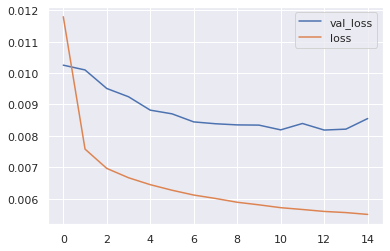

In [97]:
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='loss')
plt.legend()
plt.show

There is quite some difference in the loss function for this model. This could mean that the model is overfitting the results, thus being too complex. The early stopping is a good way of keeping the overfitting from not becoming too bad. In order to find a better suited model the complexity should be reduced somewhat, or dropout could be added to the layers as this has proven to be effective against overfitting. 

In [98]:
preds = np.squeeze(model.predict(map_valid, 1024, verbose=1))

83/83 [==============================] - 1s 4ms/step


Define functions for calculating the RMSPE from the logaritmically transformed data. 

In [28]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)
  
def my_rmspe(y_valid_array, y_pred_array):
  return np.sqrt(np.mean(np.square((y_pred_array - y_valid_array)/y_valid_array)))

Perform an inverse log transform to the predictions and validation. 

In [99]:
preds_array = log_max_inv(preds, max_log_y)
valid_array = log_max_inv(np.array(y_valid), max_log_y)
print('Prediction:',preds_array, '\nValidation:', valid_array)

Prediction: [6546.688  6956.3765 9782.96   ... 4143.306  4393.663  7970.309 ] 
Validation: [5263. 6064. 8314. ... 4517. 4096. 8163.]


Printing out the 30 first predictions show that the model predicts the sales pr day fairly well. 

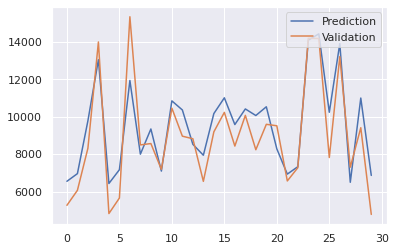

In [100]:
plt.plot(preds_array[0:30],label="Prediction")
plt.plot(valid_array[0:30],label="Validation")
plt.legend(loc = "upper right")
plt.show()

And finally calculate the RMSPE value for this model. 

In [101]:
rmspe_DNN1 = my_rmspe(valid_array, preds_array)
print('Resulting RMSPE value for DNN model 1:', np.round(rmspe_DNN1,4))

Resulting RMSPE value for DNN model 1: 0.1276


This value is within the field of the accuracy required, at the 0.1 mark, but is not enough to compete with the top performers of the kaggle competition (0.11). It is possible that with further tuning of the model this accuracy could be improved, as we saw signs of overfitting in the loss function as the mean error was higher for the validation set than the training set. 


---



### DNN Model 2

Tuning of parameters is tried out in order to optimize the results from the first DNN model. As previously mentioned, overfitting was observed from the loss function. Ways of combating this include reducing the complexity of the model, using dropout or early stopping. As early stopping is already used, this new model will be tuned by reducing the number of neurons in each layer and adding dropout. 

For each existing layer, the number of neurons are reduced by 20%. In addition, a dropout of 0.15 is added to the model. Dropout of 0.15 is used as this is a common value for dropout, proven to be efficient. 

Model parameters

In [32]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
x2 = Concatenate()([emb for inp,emb in embs] + [contin_out])
x2 = Dropout(0.15)(x2)
x2 = Dense(750, activation='relu', kernel_initializer='uniform')(x2)
x2 = Dropout(0.15)(x2)
x2 = Dense(400, activation='relu', kernel_initializer='uniform')(x2)
x2 = Dropout(0.15)(x2)
x2 = Dense(1, activation='sigmoid')(x2)

model2 = Model([inp for inp,emb in embs] + [contin_inp], x2)

model2.compile(optimizer = "adam", 
              loss = 'mean_absolute_error')

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Day_in (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 Month_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

The total parameters have been reduced with 1/3, from 911 846 to 624 396. This drastically reduces the complexity and should hopefully result in no overfitting. 

Fit the model

In [33]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='auto',
                                                  patience=2)

hist2 = model2.fit(map_train, y_train, batch_size=512, epochs=25,
                 verbose=1, validation_data=(map_valid, y_valid),
                 callbacks=[early_stopping])

Epoch 1/25
1485/1485 [==============================] - 22s 13ms/step - loss: 0.0144 - val_loss: 0.0125
Epoch 2/25
1485/1485 [==============================] - 17s 12ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 3/25
1485/1485 [==============================] - 19s 13ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 4/25
1485/1485 [==============================] - 17s 12ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 5/25
1485/1485 [==============================] - 17s 12ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 6/25
1485/1485 [==============================] - 17s 11ms/step - loss: 0.0081 - val_loss: 0.0092
Epoch 7/25
1485/1485 [==============================] - 17s 12ms/step - loss: 0.0078 - val_loss: 0.0089
Epoch 8/25
1485/1485 [==============================] - 17s 12ms/step - loss: 0.0076 - val_loss: 0.0088
Epoch 9/25
1485/1485 [==============================] - 19s 13ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 10/25
1485/1485 [==============================] - 17s 12m

Time used: 4min 27s.

Early stopping once again stops the number of epochs way before the limit of 25 epochs, reducing the computational time. 

In [82]:
time_DNN2 = 4.5

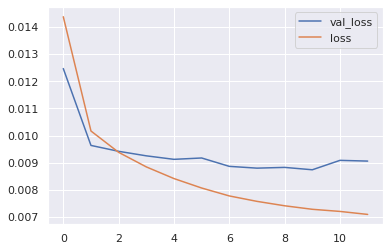

In [96]:
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.plot(hist2.history['loss'], label='loss')
plt.legend()
plt.show()

Compared to the former model it appears as if the overfitting is reduced. However, the tendency of this model could appear to approach overfitting if not for the early stop. 

Do prediction with the new model

In [35]:
preds2 = np.squeeze(model2.predict(map_valid, 1024, verbose=1))

83/83 [==============================] - 0s 3ms/step


In [36]:
preds_array2 = log_max_inv(preds2, max_log_y)
print('Prediction:',preds_array2, '\nValidation:', valid_array)

Prediction: [5297.5103 6489.667  9617.311  ... 3680.4827 3721.0378 6606.8306] 
Validation: [5263. 6064. 8314. ... 4517. 4096. 8163.]


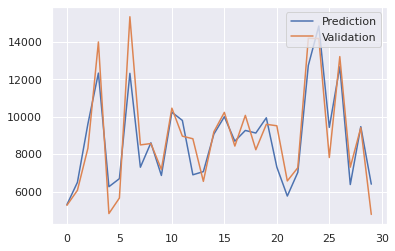

In [37]:
plt.plot(preds_array2[0:30],label="Prediction")
plt.plot(valid_array[0:30],label="Validation")
plt.legend(loc = "upper right")
plt.show()

In [49]:
rmspe_DNN2 = my_rmspe(valid_array, preds_array2)
print('Resulting RMSPE value for DNN model 2:', np.round(rmspe_DNN2,4))

Resulting RMSPE value for DNN model 2: 0.1338


The resulting RMSPE value is worse for the new model than the last one, as can also be seen in the values for the loss function. Although some overfitting has been lost, the overall performance of the new DNN is worsened. Adding dropout and reducing the complexity thus does not improve the model score. 

## 6. LGBM Model

In addition, to show another alternative to solving the problem, a LGBM (light gradient boosting machine) model is built. This is a gradient boosting framework based on decision trees. It uses two novel technologies: Gradient-based One Side Sampling and Exclucive Feature Bundling (EFB) (GeekforGeeks, 2021). 

This model is collected from the file '07-lightGBM.ipynb' with the data processed as in files 01-04. 



Set up environment

In [39]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from lightgbm import LGBMRegressor

import pandas as pd
import numpy as np
import datetime
!pip install pandas_summary
from pandas_summary import DataFrameSummary
from google.colab import drive

drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import files 

In [40]:
BASE = '/content/drive/MyDrive/Neural Networks/TP2/'
df = pd.read_feather(BASE+'train_normalized_data.fth')
df_test = pd.read_feather(BASE+'test_normalized_data.fth')

Create variables, continous and categorical

In [41]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
  'Promo', 'SchoolHoliday']


In [42]:
y_out_columns = ['Sales']

df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

X_train = df_train[cat_vars + contin_vars]
X_val = df_val[cat_vars + contin_vars]
X_test = df_test[cat_vars + contin_vars]



Logaritmic transformation of variables.

In [43]:
log_output = True
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std

Model parameters:

In [44]:
min_child_samples=5
n_estimators=4000
learning_rate=0.05
model = LGBMRegressor(min_child_samples=min_child_samples,
                      n_estimators=n_estimators,
                      learning_rate=learning_rate )

fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'l2', 
            "eval_set" : [(X_val, y_val.reshape(-1))],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': cat_vars
           }

In [45]:
%%time
model.fit(X_train, y_train.reshape(-1), **fit_params)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionMonthsOpen', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'Events', 'Month', 'Promo2SinceYear', 'Promo2Weeks', 'PromoInterval', 'Promo_bw', 'Promo_fw', 'SchoolHoliday_bw', 'SchoolHoliday_fw', 'State', 'StateHoliday', 'Store', 'StoreType', 'Week', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	valid's l2: 0.000220884	valid's l2: 0.000220884
[200]	valid's l2: 0.000169813	valid's l2: 0.000169813
[300]	valid's l2: 0.0001535	valid's l2: 0.0001535
[400]	valid's l2: 0.000145236	valid's l2: 0.000145236
[500]	valid's l2: 0.000138365	valid's l2: 0.000138365
[600]	valid's l2: 0.000134228	valid's l2: 0.000134228
[700]	valid's l2: 0.000131292	valid's l2: 0.000131292
[800]	valid's l2: 0.000129069	valid's l2: 0.000129069
[900]	valid's l2: 0.000127633	valid's l2: 0.000127633
[1000]	valid's l2: 0.000126103	valid's l2: 0.000126103
[1100]	valid's l2: 0.000124837	valid's l2: 0.000124837
[1200]	valid's l2: 0.000123777	valid's l2: 0.000123777
[1300]	valid's l2: 0.000123213	valid's l2: 0.000123213
[1400]	valid's l2: 0.000122733	valid's l2: 0.000122733
[1500]	valid's l2: 0.000121663	valid's l2: 0.000121663
[1600]	valid's l2: 0.000121255	valid's l2: 0.000121255
[1700]	valid's l2: 0.000120929	valid's l2: 0.000120929
[1800]	valid's 

LGBMRegressor(learning_rate=0.05, min_child_samples=5, n_estimators=4000)

Time used: 7min 44s

In [59]:
time_lgbm = 7.75

In [46]:
model.score(X_val, y_val)

0.9173459696337822

Perform inverse logaritmic function.

In [47]:
if log_output:
    y_pred_train = np.exp(model.predict(X_train, verbose=1)*max_log_y)
    y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)
    y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)
else:
    y_pred_train = model.predict(X_train, verbose=1)*y_std + y_mean
    y_pred = model.predict(X_val, verbose=1)*y_std + y_mean
    y_pred_test = model.predict(X_test, verbose=1)*y_std + y_mean

Calculate RSPME values for the sets. As in the previous model, the RMSPE value for the validation data set is used as the resulting value. 

In [48]:
# Train
train_rmspe = np.sqrt((((df_train['Sales'].values - y_pred_train)/df_train['Sales'].values)**2).sum()/len(y_pred_train))
# Validation
valid_rmspe = np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

rmspe_lgbm = valid_rmspe

print('Resulting RMSPE value for LGBM model:', np.round(rmspe_lgbm,4))

Resulting RMSPE value for LGBM model: 0.1196


The resulting RMSPE value is up there with the highest performers of the kaggle competition. This is therefore deemed to be the best alternative of the models given, for the Rossman Challenge. 

## 7. Results
Benchmarking of the models. 

Three models have been compared in this delivery: two deep neural networks and one light gradient booster machine model. Their respective RMSPE score and training time are shown below. 

In [104]:
model_rmspe = [rmspe_DNN1, rmspe_DNN2, rmspe_lgbm]
model_names = ['DNN1', 'DNN2', 'LGBM']
model_time = [time_DNN1, time_DNN2, time_lgbm]

print('SCORES')
print(' Model \t RMSPE \t Training time')
for iter in range(len(model_names)):
  print(' ',model_names[iter], ' ', np.round(model_rmspe[iter],4), ' ', model_time[iter],'min')

SCORES
 Model 	 RMSPE 	 Training time
  DNN1   0.1276   5.5 min
  DNN2   0.1338   4.5 min
  LGBM   0.1196   7.75 min


The LGBM model has the best score and is thus the preferred model. DNN1 is not far away however, with the difference in RMSPE score being only 0.008. 

It is also seen that the high score comes at the price of more computational power, as it clearly uses more time than the other models. 

An explanation behind the superiority of the LGBM model comes from the paper "Entity Embeddings of Categorical Variables". As stated in the introduction, neural networks are yet to be as prominent for structured data sets as common machine learning algorithms. As neural networks assumes certain levels of continuity, it is not suited for approximating non-continous functions (as is needed in structured data sets). Tree-based methods however, like the LGBM model, do not assume continuity and can divide the states of a variable as fine as necessary (Guo & Berkhahn, 2016). 

Although the tree-based model should (as stated above) and does obtain a higher score than the DNN, the DNN is not far away. This shows how entity embedding improves the performance of DNNs when training on structured data sets. An interesting aspect to consider in the exercise would be the performance of a DNN on the data set without entity embedding, in order to see the difference it makes. 


## Bibliography 

- Guo, C. & Berkhahn, F. (2016) *Entity Embeddings of Categorical Variables* Available from: https://doi.org/10.48550/arXiv.1604.06737

- Radecic, D. (2021) *Time series from scratch - train/test splits and evaluation metrics* Available from: https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37 (Accessed 25.10.2022)

- Zulkifli, H. (2019) *Understanding entity embeddings and its application* Available from: https://towardsdatascience.com/understanding-entity-embeddings-and-its-application-69e37ae1501d (Accessed 22.10.2022)

- GeeksforGeeks (2021) *Light GBM (Light Gradient Boosting Machine)* Available from: https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/ (Accessed 26.10.2022)
